In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='whitegrid')
import matplotlib.pyplot as plt
import datetime
import random
import glob
import os

In [2]:
mon = pd.read_csv('data/monday.csv', sep=';')
tue = pd.read_csv('data/tuesday.csv', sep=';')
wed = pd.read_csv('data/wednesday.csv', sep=';')
thu = pd.read_csv('data/thursday.csv', sep=';')
fri = pd.read_csv('data/friday.csv', sep=';')

In [3]:
mon.customer_no = mon.customer_no + 10000
tue.customer_no = tue.customer_no + 20000
wed.customer_no = wed.customer_no + 30000
thu.customer_no = thu.customer_no + 40000
fri.customer_no = fri.customer_no + 50000

#### EDA

In [4]:
df = pd.concat([mon,tue,wed,thu,fri], ignore_index=True)

df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['weekday'] = df['timestamp'].dt.day_name()
df['time'] = df['timestamp'].dt.time
#df['hour'] = df['timestamp'].dt.hour
#df['minute'] = df['timestamp'].dt.minute

In [5]:
df.head()

,timestamp,customer_no,location,time
0,2019-09-02 07:03:00,10001,dairy,07:03:00
1,2019-09-02 07:03:00,10002,dairy,07:03:00
2,2019-09-02 07:04:00,10003,dairy,07:04:00
3,2019-09-02 07:04:00,10004,dairy,07:04:00
4,2019-09-02 07:04:00,10005,spices,07:04:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24877 entries, 0 to 24876
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    24877 non-null  datetime64[ns]
 1   customer_no  24877 non-null  int64         
 2   location     24877 non-null  object        
 3   time         24877 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 777.5+ KB


In [7]:
df.isna().sum()

timestamp      0
customer_no    0
location       0
time           0
dtype: int64

##### Plotting

- Calculate the total number of customers in each section

In [8]:
df.groupby('location')['customer_no'].count()

location
checkout    7417
dairy       4679
drinks      3905
fruit       5122
spices      3754
Name: customer_no, dtype: int64

- Calculate the total number of customers in each section over time

In [9]:
#Calculate the total number of customers in each section over time
df.groupby(['time', 'location'])['customer_no'].count()

time      location
07:00:00  dairy       3
          drinks      3
          fruit       4
07:01:00  checkout    2
          dairy       4
                     ..
21:50:00  checkout    2
          dairy       3
          drinks      1
          fruit       2
          spices      1
Name: customer_no, Length: 4383, dtype: int64

- Display the number of customers at checkout over time



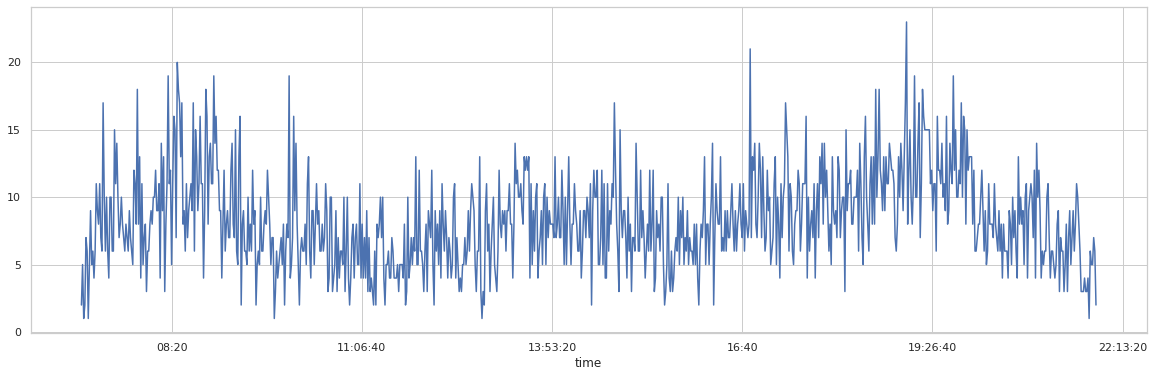

In [10]:
dftime = df[df['location'] == 'checkout']
dftime.groupby('time')['customer_no'].count().plot(figsize=(20,6));

- Calculate the time each customer spent in the market

In [11]:
#getting minutes between each location
df['diff'] = df.groupby(['customer_no'])['timestamp'].diff().astype('timedelta64[m]')
df.fillna(0, inplace=True)

In [12]:
#sum of the minutes / total time spent
df_time = pd.DataFrame(df.groupby('customer_no')['diff'].sum())
df_time.reset_index(inplace=True)
df_time.rename(columns = {'diff':'time_spent'}, inplace = True)

#merging with main df
df = df.merge(df_time, how='outer')
df.head()

,timestamp,customer_no,location,time,diff,time_spent
0,2019-09-02 07:03:00,10001,dairy,07:03:00,0.0,2.0
1,2019-09-02 07:05:00,10001,checkout,07:05:00,2.0,2.0
2,2019-09-02 07:03:00,10002,dairy,07:03:00,0.0,3.0
3,2019-09-02 07:06:00,10002,checkout,07:06:00,3.0,3.0
4,2019-09-02 07:04:00,10003,dairy,07:04:00,0.0,2.0


- Calculate the total number of customers in the supermarket over time.

In [13]:
df.groupby('time')['customer_no'].count()

time
07:00:00    10
07:01:00     9
07:02:00     9
07:03:00    16
07:04:00    14
            ..
21:46:00    20
21:47:00    17
21:48:00    23
21:49:00    18
21:50:00     9
Name: customer_no, Length: 891, dtype: int64

In [14]:
#df.groupby(['time', 'weekday'])['customer_no'].count().plot(figsize=(20,6));

- Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).




In [15]:
df.loc[(df['location'] == 'dairy'), 'location'] = 'milk'

- Collecting transition data

In [16]:
#getting next location
df['location_next'] = df.groupby('customer_no')['location'].shift(-1)

#filling nan values for customers that never checked out
df.loc[(df['location'] != 'checkout') & (df['location_next'].isna()), 'location_next'] = 'checkout'

#filling nan values for customers who did checkout
df.loc[(df['location'] == 'checkout') & (df['location_next'].isna()), 'location_next'] = 'done'

- Getting location path

In [17]:
df['first_letters'] = df['location'].str[0]

In [18]:
df['diff_2'] = df['diff'].shift(-1)
df['diff_2'].fillna(0.0, inplace=True)
df['diff_2'].replace(0.0, 1.0, inplace=True)
df

,timestamp,customer_no,location,time,diff,time_spent,location_next,first_letters,diff_2
0,2019-09-02 07:03:00,10001,milk,07:03:00,0.0,2.0,checkout,m,2.0
1,2019-09-02 07:05:00,10001,checkout,07:05:00,2.0,2.0,done,c,1.0
2,2019-09-02 07:03:00,10002,milk,07:03:00,0.0,3.0,checkout,m,3.0
3,2019-09-02 07:06:00,10002,checkout,07:06:00,3.0,3.0,done,c,1.0
4,2019-09-02 07:04:00,10003,milk,07:04:00,0.0,2.0,checkout,m,2.0
...,...,...,...,...,...,...,...,...,...
24872,2019-09-06 21:50:00,51507,checkout,21:50:00,2.0,2.0,done,c,1.0
24873,2019-09-06 21:48:00,51508,milk,21:48:00,0.0,2.0,checkout,m,2.0
24874,2019-09-06 21:50:00,51508,checkout,21:50:00,2.0,2.0,done,c,1.0
24875,2019-09-06 21:50:00,51509,drinks,21:50:00,0.0,0.0,checkout,d,1.0


In [19]:
df['diff_2'] = df['diff_2'].astype(int)
df['first_letters'] = df['first_letters'] * df['diff_2']
df

,timestamp,customer_no,location,time,diff,time_spent,location_next,first_letters,diff_2
0,2019-09-02 07:03:00,10001,milk,07:03:00,0.0,2.0,checkout,mm,2
1,2019-09-02 07:05:00,10001,checkout,07:05:00,2.0,2.0,done,c,1
2,2019-09-02 07:03:00,10002,milk,07:03:00,0.0,3.0,checkout,mmm,3
3,2019-09-02 07:06:00,10002,checkout,07:06:00,3.0,3.0,done,c,1
4,2019-09-02 07:04:00,10003,milk,07:04:00,0.0,2.0,checkout,mm,2
...,...,...,...,...,...,...,...,...,...
24872,2019-09-06 21:50:00,51507,checkout,21:50:00,2.0,2.0,done,c,1
24873,2019-09-06 21:48:00,51508,milk,21:48:00,0.0,2.0,checkout,mm,2
24874,2019-09-06 21:50:00,51508,checkout,21:50:00,2.0,2.0,done,c,1
24875,2019-09-06 21:50:00,51509,drinks,21:50:00,0.0,0.0,checkout,d,1


In [20]:
path = pd.DataFrame(df.groupby(['customer_no'])['first_letters'].sum())
path.reset_index(inplace=True)
path.rename(columns = {'first_letters':'path'}, inplace=True)

#merging dfs
df = df.merge(path, how='outer')
df

,timestamp,customer_no,location,time,diff,time_spent,location_next,first_letters,diff_2,path
0,2019-09-02 07:03:00,10001,milk,07:03:00,0.0,2.0,checkout,mm,2,mmc
1,2019-09-02 07:05:00,10001,checkout,07:05:00,2.0,2.0,done,c,1,mmc
2,2019-09-02 07:03:00,10002,milk,07:03:00,0.0,3.0,checkout,mmm,3,mmmc
3,2019-09-02 07:06:00,10002,checkout,07:06:00,3.0,3.0,done,c,1,mmmc
4,2019-09-02 07:04:00,10003,milk,07:04:00,0.0,2.0,checkout,mm,2,mmc
...,...,...,...,...,...,...,...,...,...,...
24872,2019-09-06 21:50:00,51507,checkout,21:50:00,2.0,2.0,done,c,1,mmc
24873,2019-09-06 21:48:00,51508,milk,21:48:00,0.0,2.0,checkout,mm,2,mmc
24874,2019-09-06 21:50:00,51508,checkout,21:50:00,2.0,2.0,done,c,1,mmc
24875,2019-09-06 21:50:00,51509,drinks,21:50:00,0.0,0.0,checkout,d,1,d


In [21]:
lista = []
for p in df['path']:
    x = list(p)
    x.insert(0, "e")
    lista.append(x)
    
    if x[-1] != 'c':
          x.append('c')
df['path'] = lista

In [22]:
customer = df[['customer_no', 'path']]
customer.set_index('customer_no', inplace=True)
df_customer = pd.DataFrame(customer.groupby('customer_no').first().explode('path'))
df_customer

,path
customer_no,
10001,e
10001,m
10001,m
10001,c
10002,e
...,...
51509,d
51509,c
51510,e


In [23]:
#change the name of the location
df_customer.columns = ["location"]

#reset the index to group them and add the next location
df_customer.reset_index(inplace=True)

#add the next location
df_customer["location_next"] = df_customer.groupby('customer_no')['location'].shift(-1)

#replace the missing values with "c" for checkout
df_customer["location_next"].fillna("c", inplace=True)
df_customer

,customer_no,location,location_next
0,10001,e,m
1,10001,m,m
2,10001,m,c
3,10001,c,c
4,10002,e,m
...,...,...,...
61371,51509,d,c
61372,51509,c,c
61373,51510,e,s
61374,51510,s,c


In [24]:
M = pd.crosstab(df_customer['location'], df_customer['location_next'], normalize=0)
M

location_next,c,d,f,m,s
location,,,,,
c,1.000000,0.000000,0.000000,0.000000,0.000000
d,0.215710,0.598499,0.087909,0.010899,0.086983
e,0.000000,0.153526,0.377435,0.287576,0.181464
f,0.201605,0.054847,0.596947,0.095924,0.050677
m,0.103466,0.058569,0.049848,0.736750,0.051367
s,0.150685,0.163109,0.090953,0.193214,0.402039


- counting each transition

In [25]:
df_trans = pd.DataFrame(df.groupby('customer_no')['location_next'].value_counts(normalize=True).unstack())
df_trans.fillna(0, inplace=True)
df_trans.reset_index(0, inplace=True)
df_trans.set_index('customer_no', inplace=True)
df_trans

location_next,checkout,done,drinks,fruit,milk,spices
customer_no,,,,,,
10001,0.5,0.5,0.0,0.0,0.0,0.0
10002,0.5,0.5,0.0,0.0,0.0,0.0
10003,0.5,0.5,0.0,0.0,0.0,0.0
10004,0.5,0.5,0.0,0.0,0.0,0.0
10005,0.5,0.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
51506,1.0,0.0,0.0,0.0,0.0,0.0
51507,0.5,0.5,0.0,0.0,0.0,0.0
51508,0.5,0.5,0.0,0.0,0.0,0.0


- calculating transition matrix

In [26]:
#Probability of next location
P = pd.crosstab(df_customer['location'], df_customer['location_next'], normalize=0)
P

# add an extra entrace column
P["e"] = 0

# renaming the index and the columns

P = P.rename(
    columns={"c":"checkout", "d":"drinks", "e":"entrance", "f":"fruits", "m":"milk", "s":"spices"},
    index={"c":"checkout", "d":"drinks", "e":"entrance", "f":"fruits", "m":"milk", "s":"spices"}
    )

# change the order of the columns

P = P.reindex(
    columns= ["entrance", "milk", "spices", "fruits", "drinks", "checkout"], 
    index= ["entrance", "milk", "spices", "fruits", "drinks", "checkout"]
)

P

location_next,entrance,milk,spices,fruits,drinks,checkout
location,,,,,,
entrance,0,0.287576,0.181464,0.377435,0.153526,0.000000
milk,0,0.736750,0.051367,0.049848,0.058569,0.103466
spices,0,0.193214,0.402039,0.090953,0.163109,0.150685
fruits,0,0.095924,0.050677,0.596947,0.054847,0.201605
drinks,0,0.010899,0.086983,0.087909,0.598499,0.215710
checkout,0,0.000000,0.000000,0.000000,0.000000,1.000000


#### Customer classes

In [39]:
# create the class customer

place = P.columns

class Customer:

    '''A customer that moves through the supermarket'''

    def __init__(self, name, state="entrance"):
        self.name = name
        self.state = state
        #self.entrance = entrance
        #self.transition_probs= transition_probs
    
    def __repr__(self):
        if self.state == "checkout":
            return f'<{self.name} has left the building>'
        return f'<{self.name} is in the {self.state} aile>'

    def next_state(self):

    #'''where will the custmoer go to'''

        #self.state = np.random.choice(P.columns, p=P.loc[self.state])
        #print(self.state)
        probabilities = P.loc[self.state]
        if self.state != 'checkout':
            self.state= random.choices(place, weights=probabilities)[0]

In [40]:

cust1 = Customer("Margaret", "spices")
cust1.name
cust1.state

cust1.next_state()
print(cust1)

<Margaret is in the spices aile>


In [52]:
# Create a loop that creates n customers
name= []

for i in range(10):
    name.append("customer" + str(i))
for n in name:
    x= np.random.choice(P.columns)
    n = Customer(n, x)
    n.next_state()
    print(n)

<customer0 has left the building>
<customer1 is in the milk aile>
<customer2 has left the building>
<customer3 is in the drinks aile>
<customer4 is in the milk aile>
<customer5 is in the milk aile>
<customer6 is in the milk aile>
<customer7 is in the fruits aile>
<customer8 is in the drinks aile>
<customer9 has left the building>
